## LINE通知

In [1]:
#LINE BOT  ON

import requests

class LINENotifyBot(object):
    API_URL = 'https://notify-api.line.me/api/notify'
    def __init__(self, access_token):
        self.__headers = {'Authorization': 'Bearer ' + access_token}

    def send(
        self,
        message,
        image=None,
        sticker_package_id=None,
        sticker_id=None,
    ):
        payload = {
            'message': message,
            'stickerPackageId': sticker_package_id,
            'stickerId': sticker_id,
        }
        files = {}
        if image != None:
            files = {'imageFile': open(image, 'rb')}
        r = requests.post(
            LINENotifyBot.API_URL,
            headers=self.__headers,
            data=payload,
            files=files,
        )
print("LINE BOTを起動します.")

LINE BOTを起動します.


# DQN
参考：https://book.mynavi.jp/manatee/detail/id=89831

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



pygame 2.5.2 (SDL 2.28.3, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Tensorboard 設定
ex. tensorboard --logdir [logs へのパス]


In [3]:
from torch.utils.tensorboard import SummaryWriter

# log_dirでlogのディレクトリを指定
writer = SummaryWriter(log_dir="./logs")

c:\Users\KaedeYamazaki\Desktop\py_venv\mujoco_env\lib\site-packages\torch\utils\tensorboard\__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
c:\Users\KaedeYamazaki\Desktop\py_venv\mujoco_env\lib\site-packages\torch\utils\tensorboard\__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):



## 動画保存

In [4]:
from matplotlib.animation import FuncAnimation

## 準備

In [5]:
# namedtupleを生成
from collections import namedtuple
 
Transition = namedtuple(
    'Transition', ('state', 'action', 'next_state', 'reward'))

## Roomba simulator

In [6]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import random

class RoombaSimulator:
    def __init__(self):
        self.world_pos_position = [0, 0]  # 初期位置 [x, y]
        self.world_pos_position_pre = [0, 0]
        self.ball_pos_position = [0, 0]  # ボールの初期位置 [x, y]
        self.odometry_position = [0, 0]  # オドメトリ
        self.odometry_position_pre = [0, 0]

        self.world_orientation = 0   # 初期姿勢 (rad)
        self.orientation = 0

        self.left_wheel_rotation = 0  # 左車輪の回転角度 (rad)
        self.right_wheel_rotation = 0  # 右車輪の回転角度 (rad)

        self.wheel_radius = 0.072  # 車輪の半径 (50mmをmに変換)
        self.tread = 0.235  # トレッド
        self.size = 0.165 # Roombaの半径

        self.one_side_of_area = 1 #行動環境の一辺の長さ

        self.delta_x = 0
        self.delta_y = 0
        self.delta_theta = 0

        self.vertex1 = (0,0)
        self.vertex2 = (0,0)
        self.vertex3 = (0,0)
        self.vertex4 = (0,0)

    def random_pos(self):
        self.world_pos_position = [random.uniform(-0.5, 0.5), random.uniform(-0.5, 0.5)]  # 初期位置 [x, y]
        self.ball_pos_position = [random.uniform(-0.5, 0.5), random.uniform(-0.5, 0.5)]  # ボールの初期位置 [x, y]
        self.world_orientation = random.uniform(-3.14, 3.14)


    def odometry_update(self, left_wheel_rotation_delta, right_wheel_rotation_delta):
        # 車輪の回転角度を更新
        self.left_wheel_rotation += left_wheel_rotation_delta
        self.right_wheel_rotation += right_wheel_rotation_delta

        # Roombaの位置と姿勢を更新
        left_wheel_distance = left_wheel_rotation_delta * self.wheel_radius
        right_wheel_distance = right_wheel_rotation_delta * self.wheel_radius

        delta_distance = (left_wheel_distance + right_wheel_distance) / 2
        self.delta_theta = (right_wheel_distance - left_wheel_distance) / self.tread

        self.delta_x = delta_distance * np.cos(self.orientation)
        self.delta_y = delta_distance * np.sin(self.orientation)

        self.odometry_position[0] += self.delta_x
        self.odometry_position[1] += self.delta_y
        self.orientation += self.delta_theta


    def world_pos_update(self):
        # Roombaのワールド座標系での移動を計算
        world_delta_x = np.cos(self.world_orientation) * self.delta_x - np.sin(self.world_orientation) * self.delta_y
        world_delta_y = np.sin(self.world_orientation) * self.delta_x + np.cos(self.world_orientation) * self.delta_y

        # Roombaのワールド座標系での位置を更新
        self.world_pos_position[0] += world_delta_x
        self.world_pos_position[1] += world_delta_y

        #壁に突っ込んだら，座標を更新しない．
        if abs(self.world_pos_position[0])+self.size < self.one_side_of_area/2 and\
           abs(self.world_pos_position[1])+self.size < self.one_side_of_area/2:

            self.world_pos_position_pre[0] = self.world_pos_position[0]
            self.world_pos_position_pre[1] = self.world_pos_position[1]

            self.odometry_position_pre[0] = self.odometry_position[0]
            self.odometry_position_pre[1] = self.odometry_position[1]

        else:
            self.world_pos_position[0] = self.world_pos_position_pre[0]
            self.world_pos_position[1] = self.world_pos_position_pre[1]

            self.odometry_position[0] = self.odometry_position_pre[0]
            self.odometry_position[1] = self.odometry_position_pre[1]

        # Roombaのワールド座標系での回転を更新
        self.world_orientation += self.delta_theta

        '''ホモグラフィ変換された視野'''
        trapezoid_length_Top_side = 0.2  # 台形の下辺の長さ
        trapezoid_length_Bottom_side = 0.5  # 台形の下辺の長さ
        trapezoid_height = 0.5  # 台形の高さ

        top_side_offset_Xcom = trapezoid_length_Top_side/2 * np.cos(self.world_orientation + np.pi/2)
        top_side_offset_Ycom = trapezoid_length_Top_side/2 * np.sin(self.world_orientation + np.pi/2)
        bottom_side_offset_Xcom = trapezoid_length_Bottom_side/2 * np.cos(self.world_orientation + np.pi/2)
        bottom_side_offset_Ycom = trapezoid_length_Bottom_side/2 * np.sin(self.world_orientation + np.pi/2)

        height_offset_Xcom = trapezoid_height * np.cos(self.world_orientation)
        height_offset_Ycom = trapezoid_height * np.sin(self.world_orientation)

        size_offset_Xcom = self.size * np.cos(self.world_orientation)
        size_offset_Ycom = self.size * np.sin(self.world_orientation)

        # 台形の頂点座標
        # 左端
        self.vertex1 = (self.world_pos_position[0] -  top_side_offset_Xcom + size_offset_Xcom,
                   self.world_pos_position[1] -  top_side_offset_Ycom + size_offset_Ycom)

        # 左上
        self.vertex4 = ((self.world_pos_position[0] -  bottom_side_offset_Xcom) + height_offset_Xcom,
                   (self.world_pos_position[1] -  bottom_side_offset_Ycom) + height_offset_Ycom)

        # 右端
        self.vertex2 = (self.world_pos_position[0] +  top_side_offset_Xcom + size_offset_Xcom,
                   self.world_pos_position[1] +  top_side_offset_Ycom + size_offset_Ycom)

        # 右上
        self.vertex3 = ((self.world_pos_position[0] +  bottom_side_offset_Xcom) + height_offset_Xcom,
                   (self.world_pos_position[1] +  bottom_side_offset_Ycom) + height_offset_Ycom)

    def plot(self):
        # Roombaの位置と姿勢をMatplotlibでプロット
        plt.clf()

        # 青い点でRoombaの中心を表現
        plt.plot(self.world_pos_position[0], self.world_pos_position[1], 'bo')

        # 赤い点でRoombaの中心を表現
        plt.plot(self.ball_pos_position[0], self.ball_pos_position[1], 'ro')

        # 半径0.165の円をプロット
        circle = plt.Circle((self.world_pos_position[0], self.world_pos_position[1]), 0.165, color='cyan', fill=False)
        plt.gca().add_patch(circle)

        # 赤い矢印で姿勢を表現
        line_length = 0.3
        line_dx = line_length * np.cos(self.world_orientation)
        line_dy = line_length * np.sin(self.world_orientation) #:.2f .format(self.world_pos_position[0])
        plt.arrow(self.world_pos_position[0], self.world_pos_position[1], line_dx, line_dy, color='red', width=0.02)

        # 視野を描画
        trapezoid = plt.Polygon([self.vertex1, self.vertex2,self.vertex3,self.vertex4], fill=False, edgecolor='green')

        plt.gca().add_patch(trapezoid)

        print('{:.3f}'.format(self.world_pos_position[0]),
              ',','{:.3f}'.format(self.world_pos_position[1]),
              ',','{:.3f}'.format(self.world_orientation),
              ',','{:.3f}'.format(self.odometry_position[0]),
              ',','{:.3f}'.format(self.odometry_position[0]),
              ',','{:.3f}'.format(self.orientation))

        # グラフを正方形にし、目盛りを1ずつ増加
        plt.axis('equal')
        plt.xticks(np.arange(-2, 3, 0.5))
        plt.yticks(np.arange(-2, 3, 0.5))

        plt.title("Roomba Simulator")
        plt.grid(True)

    def is_inside_trapezoid(self):
        def cross_product(ax, ay, bx, by, cx, cy):
            return (bx - ax) * (cy - ay) - (by - ay) * (cx - ax)

        # 連続する頂点の各ペアについて外積を計算する．
        cross_product_ver1to2 = cross_product(self.vertex1[0], self.vertex1[1], self.vertex2[0], self.vertex2[1], self.ball_pos_position[0], self.ball_pos_position[1])
        cross_product_ver2to3 = cross_product(self.vertex2[0], self.vertex2[1], self.vertex3[0], self.vertex3[1], self.ball_pos_position[0], self.ball_pos_position[1])
        cross_product_ver3to4 = cross_product(self.vertex3[0], self.vertex3[1], self.vertex4[0], self.vertex4[1], self.ball_pos_position[0], self.ball_pos_position[1])
        cross_product_ver4to1 = cross_product(self.vertex4[0], self.vertex4[1], self.vertex1[0], self.vertex1[1], self.ball_pos_position[0], self.ball_pos_position[1])

        # ballが台形内に入っているかを判定する．
        if (cross_product_ver1to2 >= 0 and cross_product_ver2to3 >= 0 and
                cross_product_ver3to4 >= 0 and cross_product_ver4to1 >= 0) or \
        (cross_product_ver1to2 <= 0 and cross_product_ver2to3 <= 0 and
                cross_product_ver3to4 <= 0 and cross_product_ver4to1 <= 0):
            return True
        else:
            return False

    def get_world_pos_ori(self):
        return self.world_pos_position[0],self.world_pos_position[1],self.world_orientation

    def get_ball_pos(self):
        if self.is_inside_trapezoid():
            return self.ball_pos_position[0], self.ball_pos_position[1]
        else:
            return [-10,-10]

    def touch_ball(self):
        if np.sqrt((self.world_pos_position[0]-self.ball_pos_position[0])**2
                   +(self.world_pos_position[0]-self.ball_pos_position[0])**2) <= 0.165:
            return True
        else:
            return False



# # アニメーション用の関数
# def animate(frame):
#     # 左右の車輪の回転角度の差分を仮想的に生成
#     left_wheel_rotation_delta = 1 * 1e-1 #0.1 * np.sin(frame * 0.1)
#     right_wheel_rotation_delta = 1 * 1e-1 #0.1 * np.cos(frame * 0.1)

#     roomba_simulator.odometry_update(left_wheel_rotation_delta, right_wheel_rotation_delta)
#     roomba_simulator.world_pos_update()
#     if roomba_simulator.is_inside_trapezoid():
#         print("see ball")
#     roomba_simulator.plot()

# # RoombaSimulatorのインスタンス作成
# roomba_simulator = RoombaSimulator()

# # アニメーションの作成
# animation = FuncAnimation(plt.figure(), animate, frames=range(200), interval=50)

# # アニメーションの保存
# animation.save('./python/movie/roomba_simulation.mp4', writer='ffmpeg', fps=20, dpi=300)

# # アニメーションの表示
# # plt.show()

## Roomba environment
参考：https://developers.agirobots.com/jp/openai-gym-custom-env/

In [7]:
import torch
import gymnasium as gym
from gymnasium import spaces

class RoombaEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(RoombaEnv, self).__init__()
        self.roomba_simulator = RoombaSimulator()
        pos_limit_x,pos_limit_y = [self.roomba_simulator.one_side_of_area / 2] * 2
        self.action_space = gym.spaces.Discrete(9)       # エージェントが取りうる行動空間を定義
        self.observation_space = gym.spaces.Box(
    low=np.array([-pos_limit_x, -pos_limit_y, np.NINF, -pos_limit_x, -pos_limit_y], dtype=np.float32),
    high=np.array([pos_limit_x, pos_limit_y, np.inf, pos_limit_x, pos_limit_y], dtype=np.float32),
    shape=(5,),
)  # roomba_x,roomba_y,roomba_ori,ball_x,ball_y
        self.reward_range = (0,1)       # 報酬の範囲[最小値と最大値]を定義

    def reset(self):
        self.roomba_simulator.random_pos()
        roomba_x,roomba_y,roomba_ori = self.roomba_simulator.get_world_pos_ori()
        ball_x,ball_y = self.roomba_simulator.get_ball_pos()

        obs = np.array([roomba_x,roomba_y,roomba_ori,ball_x,ball_y])

        return obs

    def ctrl(self,action):
        if action == 0:
            left_wheel_rotation_delta = 1 * 1e-1
            right_wheel_rotation_delta = 1 * 1e-1
        elif action == 1:
            left_wheel_rotation_delta = -1 * 1e-1
            right_wheel_rotation_delta = -1 * 1e-1
        elif action == 2:
            left_wheel_rotation_delta = 1 * 1e-1
            right_wheel_rotation_delta = -1 * 1e-1
        elif action == 3:
            left_wheel_rotation_delta = -1 * 1e-1
            right_wheel_rotation_delta = 1 * 1e-1
        elif action == 4:
            left_wheel_rotation_delta = 0
            right_wheel_rotation_delta = 1 * 1e-1
        elif action == 5:
            left_wheel_rotation_delta = 1 * 1e-1
            right_wheel_rotation_delta = 0
        elif action == 6:
            left_wheel_rotation_delta = 0
            right_wheel_rotation_delta = -1 * 1e-1
        elif action == 7:
            left_wheel_rotation_delta = -1 * 1e-1
            right_wheel_rotation_delta = 0
        elif action == 8:
            left_wheel_rotation_delta = 0
            right_wheel_rotation_delta = 0

        return left_wheel_rotation_delta,right_wheel_rotation_delta


    def step(self, action):
        left_wheel_rotation_delta,right_wheel_rotation_delta = self.ctrl(action)
        self.roomba_simulator.odometry_update(left_wheel_rotation_delta, right_wheel_rotation_delta)
        self.roomba_simulator.world_pos_update()
        roomba_x,roomba_y,roomba_ori = self.roomba_simulator.get_world_pos_ori()
        ball_x,ball_y = self.roomba_simulator.get_ball_pos()

        obs = np.array([roomba_x,roomba_y,roomba_ori,ball_x,ball_y])

        if self.roomba_simulator.touch_ball():
            reward = torch.FloatTensor([1.0])
            done = True
        else:
            reward = torch.FloatTensor([0.0])
            done = False

        info = {}

        return obs, reward, done, info

    # def render(self, mode='human'):
        # modeとしてhuman, rgb_array, ansiが選択可能
        # humanなら描画し, rgb_arrayならそれをreturnし, ansiなら文字列をreturnする

    # def close(self):

    # def seed(self, seed=None):


In [8]:
import gymnasium as gym
gym.envs.registration.register(id='RoombaEnv-v0',entry_point=RoombaEnv)

## Config

In [9]:
from torch import nn
# 定数の設定
ENV = 'RoombaEnv-v0'  # 使用する課題名
MAX_STEPS = 1000  # 1試行のstep数
NUM_EPISODES = 200  # 最大試行回数

GAMMA = 0.99  # 時間割引率
LEARNING_RATE = 1e-4
BATCH_SIZE = 32
CAPACITY = 10000
NUM_NEURON = 2048
CRITERION = nn.MSELoss()

memory_loss = []
update_count = []

memory_step = []
memory_reward_mean = []
episode_count = []

## ReplayMemory class

In [10]:
# 経験を保存するメモリクラスを定義します
class ReplayMemory:
    def __init__(self, CAPACITY):
        self.capacity = CAPACITY  # メモリの最大長さ
        self.memory = []  # 経験を保存する変数
        self.index = 0  # 保存するindexを示す変数

    def push(self, state, action, state_next, reward):
        """state, action, state_next, rewardをメモリに保存します"""

        if len(self.memory) < self.capacity:
            self.memory.append(None)  # メモリに保存されている経験が，最大まで満たされていない場合は，新たなに枠を確保する．

        # namedtupleのTransitionを使用し、値とフィールド名をペアにして保存します
        self.memory[self.index] = Transition(state, action, state_next, reward)

        self.index = (self.index + 1) % self.capacity  # 保存するindexを1つずらす

    def sample(self, batch_size):
        """batch_size分だけ、ランダムに保存内容を取り出します"""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## Brain class

In [11]:
# エージェントが持つ脳となるクラスです、DQNを実行
# Q関数をディープラーニングのネットワークをクラスとして定義
import random
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable


class Brain:
    def __init__(self, num_states, num_actions):
        self.update_time = 0
        self.num_states = num_states
        self.num_actions = num_actions
        self.memory = ReplayMemory(CAPACITY)

        self.model = nn.Sequential()
        self.model.add_module('fc1', nn.Linear(self.num_states, NUM_NEURON)) #512
        self.model.add_module('relu1', nn.ReLU())
        self.model.add_module('fc3', nn.Linear(NUM_NEURON, self.num_actions))

        print(self.model)  # ネットワークの形を出力
        self.optimizer = optim.Adam(self.model.parameters(), lr=LEARNING_RATE)

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return

        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))
        non_final_mask = torch.ByteTensor(tuple(map(lambda s: s is not None,batch.next_state)))

        state_batch = Variable(torch.cat(batch.state))
        action_batch = Variable(torch.cat(batch.action))
        reward_batch = Variable(torch.cat(batch.reward))
        non_final_next_states = Variable(torch.cat([s for s in batch.next_state if s is not None]))

        # 教師データの作成
        self.model.eval()
        state_action_values = self.model(state_batch).gather(1, action_batch)
        next_state_values = Variable(torch.zeros(BATCH_SIZE).type(torch.FloatTensor))
        next_state_values[non_final_mask] = self.model(non_final_next_states).data.max(1)[0]
        expected_state_action_values = reward_batch + GAMMA * next_state_values


        # パラメータの更新
        self.model.train()
        loss = CRITERION(state_action_values, expected_state_action_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # 記録
        self.update_time +=  1
        writer.add_scalar("loss vs. step", loss.detach().numpy(),self.update_time)
        memory_loss.append(loss.detach().numpy())
        update_count.append(self.update_time)


    def decide_action(self, state, episode):
        # epsilon = 0.5 * (1 / (episode + 1))
        epsilon = 0.02

        if epsilon <= np.random.uniform(0, 1):
            self.model.eval()  # ネットワークを推論モードに切り替える
            action = self.model(Variable(state)).data.max(1)[1].view(1, 1)
        else:
            action = torch.LongTensor(
                [[random.randrange(self.num_actions)]])

        return action

    def save_model(self):
        # モデル全体の保存
        torch.save(self.model, 'models/model.pth')


## Agent class

In [12]:
class Agent:
    def __init__(self, num_states, num_actions):
        """課題の状態と行動の数を設定します"""
        self.num_states = num_states  # CartPoleは状態数4を取得
        self.num_actions = num_actions  # CartPoleの行動（右に左に押す）の2を取得
        self.brain = Brain(num_states, num_actions)  # エージェントが行動を決定するための頭脳を生成

    def update_q_function(self):
        """Q関数を更新します"""
        self.brain.replay()

    def get_action(self, state, step):
        """行動の決定します"""
        action = self.brain.decide_action(state, step)
        return action

    def memorize(self, state, action, state_next, reward):
        """memoryオブジェクトに、state, action, state_next, rewardの内容を保存します"""
        self.brain.memory.push(state, action, state_next, reward)

    def record_dqn_model(self):
        self.brain.save_model()

## Environment class

In [13]:
class Environment:
    def __init__(self):
        self.env = gym.make(ENV)  # 実行する課題を設定, render_mode="human"
        self.num_states = self.env.observation_space.shape[0]  # 課題の状態と行動の数を設定
        self.num_actions = self.env.action_space.n  # CartPoleの行動（右に左に押す）の2を取得
        # 環境内で行動するAgentを生成
        self.agent = Agent(self.num_states, self.num_actions)
        self.reward_mean = np.zeros(10)  # 10試行分の報酬を格納し、平均報酬を求める．

    def list_2_Tensor(self, observation):
        state = torch.from_numpy(observation).type(torch.FloatTensor)
        state = torch.unsqueeze(state, 0)
        #ex. [0.1, 0.2, 0.3, 0.4] → [[0.1, 0.2, 0.3, 0.4]]．
        #二次元のテンソルに変更し，バッチ処理できるようにする． ex.[[0.1, 0.2, 0.3, 0.4],[...]]
        return state

    def run(self):
        for episode in range(NUM_EPISODES):  # 試行数分繰り返す
            observation = self.env.reset()  # 環境の初期化
            state = self.list_2_Tensor(observation)

            for step in range(MAX_STEPS):
                action = self.agent.get_action(state, episode)  # 行動を求める
                observation_next, reward, done, _ = self.env.step(action[0, 0].item())

                state_next = self.list_2_Tensor(observation_next)
                self.agent.memorize(state, action, state_next, reward)
                self.agent.update_q_function()

                state = state_next

                if done:
                    int_reward = int(reward.item())
                    self.reward_mean = np.hstack(
                        (self.reward_mean[1:], int_reward))
                    print('%d Episode: Finished after %d steps：10Average = %.1lf' % (episode, step + 1, self.reward_mean.mean()))
                    # writer.add_scalar("10_mean_step vs. Episode", self.total_step.mean(),episode)

                    episode_count.append(episode + 1)
                    memory_reward_mean.append(self.reward_mean)
                    memory_step.append(step+1)

                    if episode == NUM_EPISODES - 1:
                        self.agent.record_dqn_model()

                    break

# main

In [14]:
# main
roomba_env = Environment()
roomba_env.run()

c:\Users\KaedeYamazaki\Desktop\py_venv\mujoco_env\lib\site-packages\gymnasium\envs\registration.py:481: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes']
  logger.warn(
c:\Users\KaedeYamazaki\Desktop\py_venv\mujoco_env\lib\site-packages\gymnasium\utils\passive_env_checker.py:168: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.deprecation(
c:\Users\KaedeYamazaki\Desktop\py_venv\mujoco_env\lib\site-packages\gymnasium\utils\passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
c:\Users\KaedeYamazaki\Desktop\py_venv\mujoco_env\lib\site-packages\gymnasium\utils\passive_env_checker.py:189: UserWarning: WARN: The resu

Sequential(
  (fc1): Linear(in_features=5, out_features=2048, bias=True)
  (relu1): ReLU()
  (fc3): Linear(in_features=2048, out_features=9, bias=True)
)
0 Episode: Finished after 62 steps：10Average = 0.1


2 Episode: Finished after 69 steps：10Average = 0.2
3 Episode: Finished after 92 steps：10Average = 0.3
4 Episode: Finished after 452 steps：10Average = 0.4
5 Episode: Finished after 32 steps：10Average = 0.5
6 Episode: Finished after 440 steps：10Average = 0.6
7 Episode: Finished after 775 steps：10Average = 0.7
8 Episode: Finished after 240 steps：10Average = 0.8
9 Episode: Finished after 142 steps：10Average = 0.9
14 Episode: Finished after 92 steps：10Average = 1.0
19 Episode: Finished after 1 steps：10Average = 1.0
20 Episode: Finished after 1 steps：10Average = 1.0
21 Episode: Finished after 1 steps：10Average = 1.0
23 Episode: Finished after 38 steps：10Average = 1.0
24 Episode: Finished after 50 steps：10Average = 1.0
28 Episode: Finished after 1 steps：10Average = 1.0
32 Episode: Finished after 363 steps：10Average = 1.0
33 Episode: Finished after 1 steps：10Average = 1.0
37 Episode: Finished after 857 steps：10Average = 1.0
40 Episode: Finished after 70 steps：10Average = 1.0
41 Episode: Finish

# プロット

In [15]:
# env.close()
writer.close()

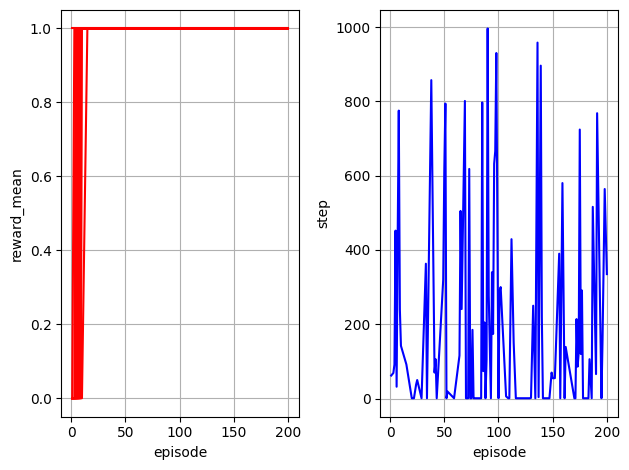

In [16]:

plt.figure(tight_layout=True)
plt.subplot(1, 2, 1)
plt.plot(episode_count,memory_reward_mean, color="red")
plt.grid()
plt.xlabel("episode")
plt.ylabel("reward_mean")

plt.subplot(1, 2, 2)
plt.plot(episode_count, memory_step, color="blue")
plt.grid()
plt.xlabel("episode")
plt.ylabel("step")

plt.savefig("img/test.png")

In [17]:
import json
import datetime

dt_now = datetime.datetime.now()

with open("./settings.json", "r", encoding="utf-8") as f:
        j = json.load(f)

token = j["token"]["my_token"]

bot = LINENotifyBot(access_token = token)
# bot.send(
# message="トレーニング完了 \n "
#         +"Data:"+str(dt_now)+"\n"
#         +"ENV:"+str(ENV)+"\n"
#         +"CRITERION:"+str(CRITERION)+"\n"
#         +"NUM_NEURON:"+str(NUM_NEURON)+"\n"
#         +"GAMMA:"+str(GAMMA)+"\n"
#         +"LEARNING_RATE:"+str(LEARNING_RATE)+"\n"
#         +"MAX_STEPS:"+str(MAX_STEPS)+"\n"
#         +"MAX_STEPS:"+str(NUM_EPISODES)+"\n"
#         +"BATCH_SIZE:"+str(BATCH_SIZE)+"\n"
#         +"CAPACITY:"+str(CAPACITY)+"\n"
#         ,
# image='img/test.png'
# )